# Open AI Gym Pendulum-v0 solution using DDPG (Deep Deterministic Policy Gradient)

<img src="./screenshots/ddpg.png" alt="drawing" width="1500"/>

In [1]:
import gym
import numpy as np
import random
import math

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import deque

### Memory Buffer class for experience replay

In [2]:
class MemoryBuffer():
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, np.array([action]), np.array([reward]), next_state, done)
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []
        
        batch = random.sample(self.buffer, batch_size)
        
        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch
    
    def __len__(self):
        return len(self.buffer)

### Actor and Critic Networks

In [3]:
class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, state):
        output = F.relu(self.fc1(state))
        output = F.relu(self.fc2(output))
        output = torch.tanh(self.fc3(output))
        return output * 2

class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, state, action):
        output = torch.cat([state, action], 1)
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output

### Agent

In [4]:
class Agent:
    def __init__(self, env, hidden_size=256, actor_lr=1e-4, critic_lr=1e-3, gamma=0.99, tau=1e-2, max_memory_size=50000):
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau
        
        self.actor = Actor(self.num_states, hidden_size, self.num_actions)
        self.actor_old = Actor(self.num_states, hidden_size, self.num_actions)
        self.critic = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic_old = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        
        for old_param, param in zip(self.actor_old.parameters(), self.actor.parameters()):
            old_param.data.copy_(param.data)
            
        for old_param, param in zip(self.critic_old.parameters(), self.critic.parameters()):
            old_param.data.copy_(param.data)
            
        self.memory_buffer = MemoryBuffer(max_memory_size)
        self.critic_criterion = nn.MSELoss()
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        
    def get_action(self, state):
        state = torch.from_numpy(state).type(torch.float).unsqueeze(0)
        action = self.actor.forward(state)
        action = action.detach().numpy().item()
        return action
    
    def update(self, batch_size):
        states, actions, rewards, next_states, done = self.memory_buffer.sample(batch_size)
        states = torch.tensor(states, dtype=torch.float)
        actions = torch.tensor(actions, dtype=torch.float)
        rewards = torch.tensor(rewards, dtype=torch.float)
        next_states = torch.tensor(next_states, dtype=torch.float)
        done = torch.tensor(done, dtype=torch.float)
        
        qvals = self.critic.forward(states, actions)
        next_actions = self.actor_old.forward(next_states)
        next_qvals = self.critic_old.forward(next_states, next_actions.detach())
        qprime = rewards + self.gamma * next_qvals
        critic_loss = self.critic_criterion(qvals, qprime)
        
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        for old_param, param in zip(self.actor_old.parameters(), self.actor.parameters()):
            old_param.data.copy_(param.data * self.tau + old_param.data * (1.0 - self.tau))
            
        for old_param, param in zip(self.critic_old.parameters(), self.critic.parameters()):
            old_param.data.copy_(param.data * self.tau + old_param.data * (1.0 - self.tau))


### Training

In [5]:
def epsilon_by_episode(episode):
    epsilon_start = 0.1
    epsilon_final = 0.00001
    epsilon_decay = 9
    #return epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
    return epsilon_start * math.exp(-1. * episode / epsilon_decay)

def plot(frame, rewards):
    clear_output(True)
    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.title("frame %s. reward: %s" % (frame, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.show()

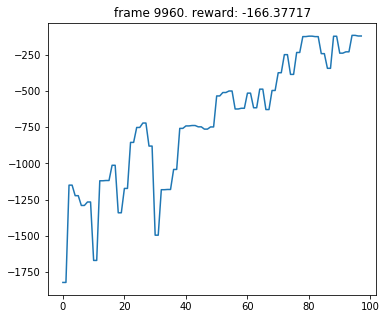

In [6]:
env = gym.make('Pendulum-v0')

agent = Agent(env)
batch_size = 128
rewards = []
avg_rewards = []
frame = 0

for episode in range(50):
    state = env.reset()
    episode_reward = 0
    
    for step in range(500):
        env.render()
        frame += 1
        
        action = agent.get_action(state)
        epsilon = epsilon_by_episode(episode)
        random_noise = torch.randn(1) * epsilon # needs decay later
        action += random_noise
        new_state, reward, done, _ = env.step(action)
        agent.memory_buffer.push(state, action, reward, new_state, done)
        
        if len(agent.memory_buffer) > batch_size:
            agent.update(batch_size)
    
        state = new_state
        episode_reward += reward
        
        if done:
            #print("episode: {}, reward: {}".format(episode, np.round(episode_reward, decimals=2)))
            break
            
        if frame%40 == 0:
            plot(frame, rewards)
    
    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[:-10]))
            
    rewards.append(episode_reward)